# 1D Steady State Convection-Diffusion

$$ f(x) - V\frac{\partial c}{\partial x} + D\frac{\partial^2 c}{\partial x^2} = 0$$

##### Data for the given example:

$$ f(x) = 5 $$
$$ c(0) = c(1) = 0 $$
$$\gamma = \frac{V}{D} = 5$$
$$ V = 1 $$

##### Equations:

$$ \frac{f(x)}{V} - \frac{\partial c}{\partial x} + \frac{1}{\gamma}\frac{\partial^2 c}{\partial x^2} = 0$$
$$ 5 - \frac{\partial c}{\partial x} + \frac{1}{5}\frac{\partial^2 c}{\partial x^2} = 0$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np

f = 5
x = np.linspace(0, 1)
gamma = 5
V = 1

### Exact solution

$$ c_{exact} = \frac{5}{V}\left(x - \frac{1 - e^{\gamma x}}{1 - e^{\gamma}}\right) $$

In [2]:
def cexact(x, pe, V):
    return f*(x - ((1 - np.exp(pe*x))/(1 - np.exp(pe))))/V

#### Plotting exact solution

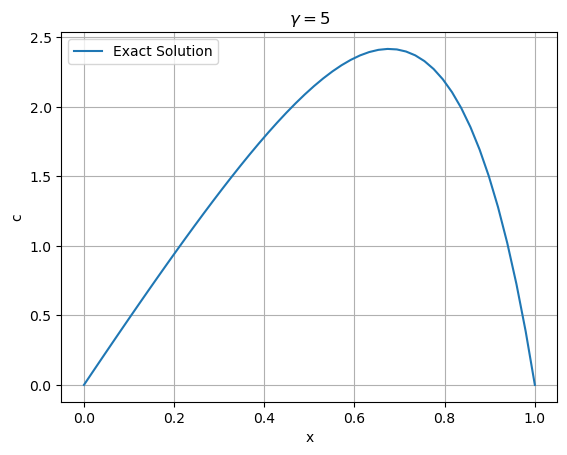

In [3]:
plt.plot(x, cexact(x, gamma, V), label = "Exact Solution")
plt.title(f"$\gamma = 5$")
plt.legend()
plt.xlabel('x')
plt.ylabel('c')
plt.grid()

### Numerical Solution 

We will use the upwind scheme for finite difference with $\Delta x = 0.05$, solved by sparse linear algebra in numpy

In [4]:
from scipy.sparse import csc_matrix, linalg as sla
from scipy.sparse import dia_matrix

xlb = 0
xub = 1
delx = 0.05

alpha = V*gamma*delx 
beta = f*alpha*delx

Nx = int(1 + (xub - xlb)/delx) # number of discretization points

ex = np.ones(Nx - 2)
coeff = np.array([(-1 - alpha)*ex, (2 + alpha)*ex, -1*ex]) # coefficient matrix
offsets = np.array([-1, 0, 1]) # diagonal matrix template

A = dia_matrix((coeff, offsets), shape = (Nx - 2, Nx - 2)) 
A = A.tocsc()

c = np.zeros(Nx)
b = np.ones(Nx - 2)*beta
A_LU = sla.splu(A)

c[1:-1] = A_LU.solve(b)
x_plot = np.linspace(xlb, xub, Nx)

#### Plotting numerical solution

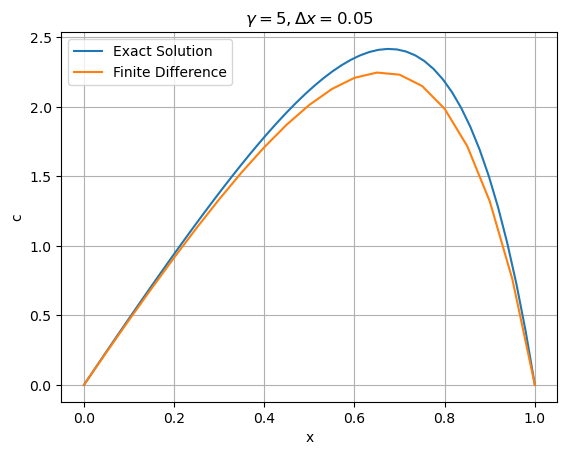

In [5]:
x_plot = np.linspace(xlb, xub, Nx)

plt.plot(x, cexact(x, gamma, 1), label = "Exact Solution")
plt.plot(x_plot, c, label = "Finite Difference")
plt.title(f"$\gamma = {gamma}, \Delta x = {delx}$")
plt.legend()
plt.xlabel('x')
plt.ylabel('c')
plt.grid()

### Physics Informed Neural Network (PINN)

We will use a physics informed neural network (PINN) to approximate the solution. The following code snippet demonstrates the basic structure of a PINN using PyTorch.

In [6]:
import torch
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

#### Making a neural network template class

In [7]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer_1 = nn.Linear(1, 10)
        self.hidden_layer_2 = nn.Linear(10, 10)
        self.hidden_layer_3 = nn.Linear(10, 10)
        self.output_layer = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.sigmoid(self.hidden_layer_1(x))
        x = torch.sigmoid(self.hidden_layer_2(x))
        x = torch.sigmoid(self.hidden_layer_3(x))
        output = self.output_layer(x)
        return output

#### Initializing a neural network

In [8]:
N_ode = Network()
N_ode = N_ode.to(device)

#### Making custom loss function

We can make a data loss function and residual governing equations loss function

In [9]:
def loss_mse(x,c):
    c_pred = N_ode(x)
    
    return torch.mean( (c-c_pred)**2 ) 

def loss_ode(x):
    x.requires_grad = True
    c = N_ode(x)
    d1 = torch.autograd.grad(c.sum(), x, create_graph=True)[0]
    d2 = torch.autograd.grad(d1.sum(), x, create_graph=True)[0]
    return torch.mean(0.5*(f/V-d1+d2/gamma)**2) + 0.5*(c[0, 0])**2 + 0.5*(c[-1, 0])**2

#### Putting it all together

In [10]:
x_ode = torch.linspace(0, 1, 100)[:, None]
optimizer_ode = torch.optim.LBFGS(N_ode.parameters())

def closure_ode():
    optimizer_ode.zero_grad()
    l_ode =  loss_ode(x_ode) #+ loss_mse(x_data, c_data) # we do not use data loss, only physics loss
    l_ode.backward()

    return l_ode

epochs_ode = 100
for i_ode in range(epochs_ode):
    optimizer_ode.step(closure_ode)

#### Evaluating and plotting PINN solution

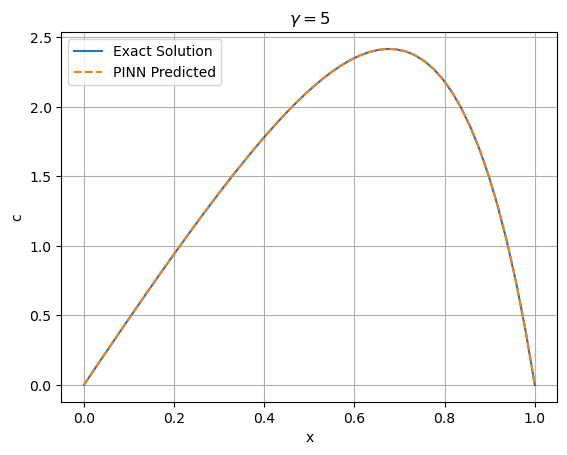

In [11]:
xx_ode = torch.linspace(0, 1, 100)[:, None]
with torch.no_grad():
    cc_ode_second = N_ode(xx_ode)

plt.plot(x, cexact(x, gamma, 1), label = "Exact Solution")
plt.plot(xx_ode, cc_ode_second, "--", label="PINN Predicted")
plt.xlabel('x')
plt.ylabel('c')
plt.title("$\gamma = 5$")
plt.legend()
plt.grid()